In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim # 最佳化資料庫
from torchvision import datasets
from matplotlib import pyplot as plt

In [2]:
import os
data_path = os.getcwd() # 在datasets內建有CIFAR10

cifar10轉tensor和標準化

In [3]:
from torchvision import transforms

transformed_cifar10 = datasets.CIFAR10(
  data_path, train=True, download=True,
  transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.4915, 0.4823, 0.4468),
  (0.2470, 0.2435, 0.2616))
]))
# val組
transformed_cifar10_val = datasets.CIFAR10(
  data_path, train=False, download=True,
  transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.4915, 0.4823, 0.4468),
  (0.2470, 0.2435, 0.2616))
]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


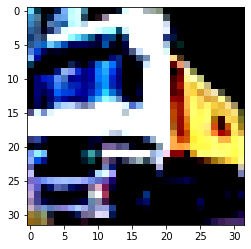

In [4]:
# tensor顯示圖片
img_t, _ = transformed_cifar10[1] # 必回傳一圖片+label
plt.imshow(img_t.permute(1, 2, 0)) # 從tensor(C,H,W)轉到numpy(H,W,C)
plt.show()

分辨飛機與鳥cifar2

In [5]:
# 只取鳥和飛機
label_map = {0: 0, 2: 1} # {飛機: 新的array的0位置, 鳥: 新的array的1位置} ex.為0就轉換為0 為2就轉換為1
class_names = ['airplane', 'bird'] 

# 若label為0和2 匯出其img和label label放到label_map轉換整數值
cifar2 = [(img, label_map[label]) 
      for img, label in transformed_cifar10
      if label in [0, 2]]
cifar2_val = [(img, label_map[label])
        for img, label in transformed_cifar10_val
        if label in [0, 2]]

練習convolution

設定conv

In [51]:
conv = nn.Conv2d(3, 16, kernel_size=5, padding=2) # 原始圖片3個channel 輸出1個channel(特徵) kernel大小為3(用3*3的特徵去篩) padding為把圖片外擴1
conv

Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

In [52]:
conv.weight.shape, conv.bias.shape # 每pixel的weight為in_ch*kernel = 3*(3*3) 所以最終的圖片會有output channel 

(torch.Size([16, 3, 5, 5]), torch.Size([16]))

圖片

In [53]:
img, _ = cifar2[0] 
output = conv(img.unsqueeze(0)) # 在最前面多一個B (原本為C*H*W) 因需要tensor去跑conv 而tensor為B*C*H*W
img.unsqueeze(0).shape, output.shape # channel從3變16 圖片大小從32*32變成30*30

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

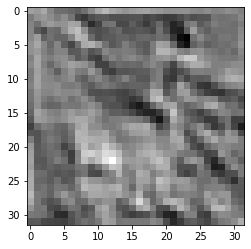

In [54]:
plt.imshow(output[0, 0, :, :].detach(), cmap='gray') # 灰階圖片顯示 0 channel
plt.show()

MaxPool縮小圖片

In [56]:
pool = nn.MaxPool2d(2) # 縮小成一半大小
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

開始訓練

model

In [ ]:
import torch.nn.functional as F

class Net(nn.Module): # 名字為Net
  def __init__(self): # 初始化
    super().__init__() # 必寫
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # 3個channel的圖片 用16種不同的kernel 每個kernal大小為3*3 
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) # 再用8種不同的kernel
    self.fc1 = nn.Linear(8 * 8 * 8, 32) # 線性訓練 因為有8個kernel 所以會輸出8層特徵 為8個channel 8*8為配合後面圖片縮小 32/2/2
    self.fc2 = nn.Linear(32, 2) # 變成possibility
    
  def forward(self, x): # 訓練順序
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) # 經過tahn神經網路 再縮小成二分之一
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = out.view(-1, 8 * 8 * 8) 
    out = torch.tanh(self.fc1(out)) # 變扁平去訓練後 再進去一個tahn
    out = self.fc2(out) # 最後輸出2個possibility
    return out

訓練一張圖片

In [ ]:
model = Net()
model(img.unsqueeze(0))
img.unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

設定訓練參數

loader

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True) 

optimizer + loss_fn

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-2) 
loss_fn = nn.CrossEntropyLoss() # 計算實際輸出(機率)與期望輸出(機率)的距離

設定train loop

In [ ]:
import datetime # 計算時間用

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs + 1): 
    loss_train = 0.0 # 設定loss
    for imgs, labels in train_loader:
      outputs = model(imgs) # 訓練 得出機率
      loss = loss_fn(outputs, labels) # 訓練機率和(0為飛機 1為鳥)比較

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item() # loss_train為累加loss 有.item()就可以跳離grad

    if epoch == 1 or epoch % 10 == 0: 
      print('{} Epoch {}, Training loss {}'.format(
        datetime.datetime.now(), epoch,
        loss_train / len(train_loader))) # 除以loss次數

train loop

In [ ]:
training_loop(
  n_epochs = 100,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,
)

2022-12-16 13:09:03.367843 Epoch 1, Training loss 0.5987437316186869
2022-12-16 13:09:44.308685 Epoch 10, Training loss 0.33150230186760044
2022-12-16 13:10:30.332060 Epoch 20, Training loss 0.29861632236249885
2022-12-16 13:11:15.162509 Epoch 30, Training loss 0.2771529577150466
2022-12-16 13:12:05.209678 Epoch 40, Training loss 0.2522733685602048
2022-12-16 13:12:51.319006 Epoch 50, Training loss 0.23575342911633718
2022-12-16 13:13:37.898546 Epoch 60, Training loss 0.22104501937794838
2022-12-16 13:14:23.829578 Epoch 70, Training loss 0.20674708409673848
2022-12-16 13:15:10.392807 Epoch 80, Training loss 0.19103221115982458
2022-12-16 13:15:55.450503 Epoch 90, Training loss 0.17464455456775466
2022-12-16 13:16:41.259977 Epoch 100, Training loss 0.16073589166922933
